In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from PIL import Image
import os
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

%matplotlib inline

In [18]:
class Config(): # argparse workaround
    def __init__(self, dataset_name, use_least_squares):
        self.dataset_name = dataset_name
        self.use_least_squares = use_least_squares
        self.advantage = 1 # of discriminator over generator
        self.noise_size = 100
        self.lr = 0.002
        self.D_maximize = True
        self.D_flip_rate = 0.002

        if dataset_name == 'MNIST':
            # self.data_path = None # first time
            self.data_path = '.'
            self.epochs = 50
            self.batch_size = 60
            self.prints_in_epoch = 1
            self.plots_in_epoch = 3
            self.label_smoothing = 0.05
        elif dataset_name == 'CelebA':
            self.data_path = '/home/nikkou/celeba' # images in /home/nikkou/celeba/train
            # dataset cropped to first 200K images
            self.epochs = 5
            self.batch_size = 100
            self.prints_in_epoch = 20
            self.plots_in_epoch = 100
            self.label_smoothing = 0.1
        else:
            raise Exception('Invalid dataset name')
            
        l_dataset_name = self.dataset_name.lower()
        if use_least_squares:
            model_name = 'LSGAN'
        else:
            model_name = 'GAN'
        l_model_name = model_name.lower()
        self.experiment_title = model_name + ', ' + self.dataset_name + ', ' + str(self.epochs) + \
                                ' epochs, D_maximize, dropout, batchnorm, flipping, smoothing'
        self.G_state_dict_f = l_model_name + '_G_' + l_dataset_name + '.state_dict'
        self.D_state_dict_f = l_model_name + '_D_' + l_dataset_name + '.state_dict'
        self.losses_f = l_model_name + '_losses_' + l_dataset_name + '.npy'

In [19]:
IMG_EXTENSIONS = [ # BEGAN code for loading CelebA
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir):
    images = []
    for root, _, fnames in sorted(os.walk(dir)):
        for fname in sorted(fnames):
            if is_image_file(fname):
                path = os.path.join(root, fname)
                item = (path, 0)
                images.append(item)

    return images

def default_loader(path):
    return Image.open(path).convert('RGB')

class ImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, target_transform=None,
                 loader=default_loader):
        imgs = make_dataset(root)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [20]:
def create_dataloader(config):
    num_workers = 12
    scale_size = 32
    
    if config.dataset_name == 'MNIST':
        if config.data_path is None:
            dataset = MNIST(root='.', transform=transforms.ToTensor(), download=True)
        else:
            dataset = MNIST(root=config.data_path, transform=transforms.ToTensor())
    elif config.dataset_name == 'CelebA':
        dataset = ImageFolder(root=config.data_path, transform=transforms.Compose([
            transforms.CenterCrop(160),
            transforms.Scale(scale_size),
            transforms.ToTensor(),
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # maybe try normalization
        ]))
    else:
        raise Exception('Invalid dataset name: ' + config.dataset_name)
        
    dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size,
                            shuffle=True, num_workers=num_workers)
    return dataloader

In [21]:
# config = Config(dataset_name = 'MNIST', use_least_squares = True)
config = Config(dataset_name = 'CelebA', use_least_squares = True)

In [22]:
# vars(config)

In [23]:
dataloader = create_dataloader(config)

In [24]:
# loader_iter = dataloader.__iter__()
# next(loader_iter)

for batch, cat in dataloader:
    break

In [25]:
print(len(dataloader))
print(batch.size())
print(cat.size())

2000
torch.Size([100, 3, 32, 32])
torch.Size([100])


In [26]:
print_every = int(np.ceil(float(len(dataloader)) / config.prints_in_epoch))
plot_every = int(np.ceil(float(len(dataloader)) / config.plots_in_epoch))

# img_shape = np.array(dataset[0][0].size())
img_shape = batch.numpy().shape[1:]
img_size = np.prod(img_shape)

### Create generator and discriminator

In [27]:
class Generator(nn.Module):
    def __init__(self, noise_size, img_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(noise_size, 500),
            nn.BatchNorm1d(500),
            nn.LeakyReLU(inplace = True),
            nn.Dropout(),
#             nn.Linear(50, 400), # training takes too long
#             nn.Dropout(inplace = True),
#             nn.ReLU(inplace = True),
            nn.Linear(500, img_size),
            nn.Sigmoid()
        ).cuda()
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size, 200),
            nn.LeakyReLU(inplace = True),
            nn.Linear(200, 50),
            nn.LeakyReLU(inplace = True),
            nn.Linear(50, 1), 
            nn.Sigmoid()
        ).cuda()
        
    def forward(self, x):
        return self.model(x)
    
class LSDiscriminator(nn.Module):
    def __init__(self, img_size):
        super(LSDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size, 200),
            nn.LeakyReLU(inplace = True),
            nn.Linear(200, 50),
            nn.LeakyReLU(inplace = True),
            nn.Linear(50, 1)
        ).cuda()
        
    def forward(self, x):
        return self.model(x)

### Задание

1) Имплементируйте GAN из статьи

2) Попробуйте LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Попробуйте оба GAN на CelebA http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

Обязательны графики.

### Training

In [28]:
def train_D(config, images):
    if images is not None:
        inp.data = images
        probs = np.random.binomial(1, 1 - config.D_flip_rate, (config.batch_size))
        probs = np.clip(probs + np.random.normal(0, config.label_smoothing, (probs.shape[0])), 0, 1)
        label.data = torch.from_numpy(probs).float().cuda() # also should be optimized as all_true
        discriminated = discriminator.forward(inp)
    else:
        noise.data = torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1).cuda()
        generated = generator.forward(noise).detach()
        probs = np.random.binomial(1, config.D_flip_rate, (config.batch_size))
        probs = np.clip(probs + np.random.normal(0, config.label_smoothing, (probs.shape[0])), 0, 1)
        label.data = torch.from_numpy(probs).float().cuda()
        discriminated = discriminator.forward(generated)

    loss_D = criterion(discriminated, label) # output, target
    res_loss_D = loss_D.cpu().data.numpy()[0]

    optim_D.zero_grad()
    loss_D.backward()
    optim_D.step()
    
    return res_loss_D

In [29]:
def train_G(config, it):
    if it % config.advantage != 0:
        return None
    
    noise.data = torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1).cuda()
    generated = generator.forward(noise)
    discriminated = discriminator.forward(generated)
#     if config.use_least_squares:
#         loss_G = criterion(discriminated, all_true)
#         res_loss_G = loss_G.cpu().data.numpy()[0]
#     else:
    if config.D_maximize:
        loss_G = -criterion(discriminated, all_false) # avoiding vanishing gradients
    else:
        loss_G = criterion(discriminated, all_true)
    if config.D_maximize:
        res_loss_G = -loss_G.cpu().data.numpy()[0] # avoiding vanishing gradients
    else:
        res_loss_G = loss_G.cpu().data.numpy()[0]

    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()
        
    return res_loss_G

In [30]:
def train(config):
    losses_list = []
    for epoch in xrange(config.epochs):
        for it, (raw_images, cat) in enumerate(dataloader):
            images = raw_images.view(config.batch_size, -1).cuda()

            while True:
                is_real = np.random.binomial(1, 0.5)
                if is_real:
                    loss_D = train_D(config, images)
                else:
                    loss_D = train_D(config, None)
                new_loss_G = train_G(config, it)
                if new_loss_G is not None: # skips G on this iter in case of advantage
                    loss_G = new_loss_G

                if is_real:
                    break # to load next real batch for D training

            if it % print_every == 0:
                print('Iteration: {}, loss_D: {:.10f}, loss_G: {:.10f}'.format(it, loss_D, loss_G))
            if it % plot_every == 0:
                losses_list.append((loss_D, loss_G))

    return losses_list
    # D loss shouldn't go to 0 or have high variance!
    # G loss shouldn't steadily increase or it's fooling D with garbage!

In [31]:
generator = Generator(config.noise_size, img_size)
if config.use_least_squares:
    discriminator = LSDiscriminator(img_size)
else:
    discriminator = Discriminator(img_size)
optim_G = optim.Adam(params = generator.parameters(), lr = config.lr)
optim_D = optim.Adam(params = discriminator.parameters(), lr = config.lr)
if config.use_least_squares:
    criterion = nn.MSELoss()
else:
    criterion = nn.BCELoss()

all_true = Variable(torch.ones((config.batch_size))).cuda() # for G loss
all_false = Variable(torch.zeros((config.batch_size))).cuda() # for G loss
is_real_vec = Variable(torch.zeros((config.batch_size))).cuda()
inp = Variable(torch.FloatTensor(config.batch_size, img_size)).cuda()
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
label = Variable(torch.FloatTensor(config.batch_size)).cuda()
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1), volatile = True).cuda()

In [32]:
vars(config)

{'D_flip_rate': 0.002,
 'D_maximize': True,
 'D_state_dict_f': 'lsgan_D_celeba.state_dict',
 'G_state_dict_f': 'lsgan_G_celeba.state_dict',
 'advantage': 1,
 'batch_size': 100,
 'data_path': '/home/nikkou/celeba',
 'dataset_name': 'CelebA',
 'epochs': 5,
 'experiment_title': 'LSGAN, CelebA, 5 epochs, D_maximize, dropout, batchnorm, flipping, smoothing',
 'label_smoothing': 0.1,
 'losses_f': 'lsgan_losses_celeba.npy',
 'lr': 0.002,
 'noise_size': 100,
 'plots_in_epoch': 100,
 'prints_in_epoch': 20,
 'use_least_squares': True}

In [33]:
losses_list = train(config)

Iteration: 0, loss_D: 0.8419979215, loss_G: 9.3966541290
Iteration: 100, loss_D: 0.9839288592, loss_G: 0.0209058337
Iteration: 200, loss_D: 0.5514699817, loss_G: 0.0300143678
Iteration: 300, loss_D: 0.0388026871, loss_G: 0.6414604783
Iteration: 400, loss_D: 0.1953540593, loss_G: 0.1571081728
Iteration: 500, loss_D: 0.2301426530, loss_G: 0.2630366087
Iteration: 600, loss_D: 0.1571935862, loss_G: 0.1889447421
Iteration: 700, loss_D: 0.0692003444, loss_G: 0.3700405061
Iteration: 800, loss_D: 0.3743495643, loss_G: 0.0508565083
Iteration: 900, loss_D: 0.2402944565, loss_G: 0.2159293741
Iteration: 1000, loss_D: 0.1620492935, loss_G: 0.3165008724
Iteration: 1100, loss_D: 0.2087440938, loss_G: 0.2594146430
Iteration: 1200, loss_D: 0.1910623312, loss_G: 0.2708720863
Iteration: 1300, loss_D: 0.2220245004, loss_G: 0.2514373660
Iteration: 1400, loss_D: 0.1452421397, loss_G: 0.3855932951
Iteration: 1500, loss_D: 0.1498246044, loss_G: 0.3158060014
Iteration: 1600, loss_D: 0.2238561958, loss_G: 0.242

In [34]:
torch.save(generator.state_dict(), config.G_state_dict_f)
torch.save(discriminator.state_dict(), config.D_state_dict_f)
losses = np.array(losses_list).T
np.save(config.losses_f, losses)

### Results

In [36]:
def load_data(config):
    global losses, generator, img_shape, img_size # needed?
    dataloader = create_dataloader(config)
    for batch, cat in dataloader:
        break
    img_shape = batch.numpy().shape[1:]
    img_size = np.prod(img_shape)
    generator = Generator(config.noise_size, img_size)
    generator.load_state_dict(torch.load(config.G_state_dict_f))
    losses = np.load(config.losses_f)

In [37]:
def demo(config):
    plt.figure(figsize = (14, 5))
    plt.suptitle(config.experiment_title)

    show_size = 16
    assert config.batch_size >= show_size
    nrows = int(np.sqrt(show_size))
    grid_size = (nrows, nrows * 3 + 1)
    gridspec.GridSpec(*grid_size)

    # show randomly generated images

    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)).cuda()
#     noise.data = torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1).cuda()
    generated = generator.forward(noise)
    new_shape = np.concatenate([np.array([config.batch_size]), img_shape])
#     new_shape = np.concatenate([np.array([config.batch_size]), img_shape[1:], img_shape[:1]])
    generated_np = np.reshape(generated.cpu().data.numpy(), new_shape)
    generated_np = np.moveaxis(generated_np, 1, -1)

    for i in xrange(show_size):
    #     print((i / show_size, i % show_size))
        plt.subplot2grid(grid_size, (i / nrows, i % nrows))
        if config.dataset_name == 'MNIST':
            plt.imshow(generated_np[i, :, :, 0], cmap='gray')
        elif config.dataset_name == 'CelebA':
            plt.imshow(generated_np[i, :, :])
        else:
            raise Exception('Invalid dataset name')
        plt.axis('off')

    # show losses

    plt.subplot2grid(grid_size, (0, nrows + 1), colspan = nrows * 2, rowspan = nrows)
    plt.plot(losses[0, :], color = 'blue', label = 'D loss')
    plt.plot(losses[1, :], color = 'red', label = 'G loss')
    leg = plt.legend()

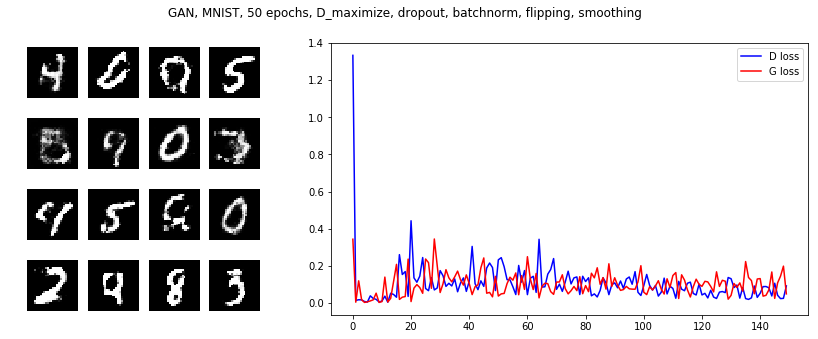

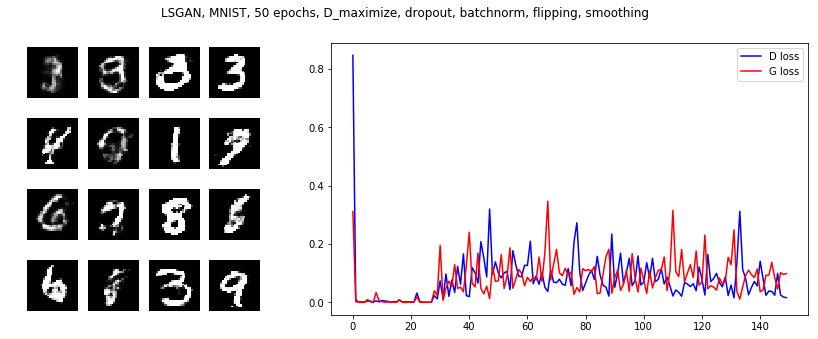

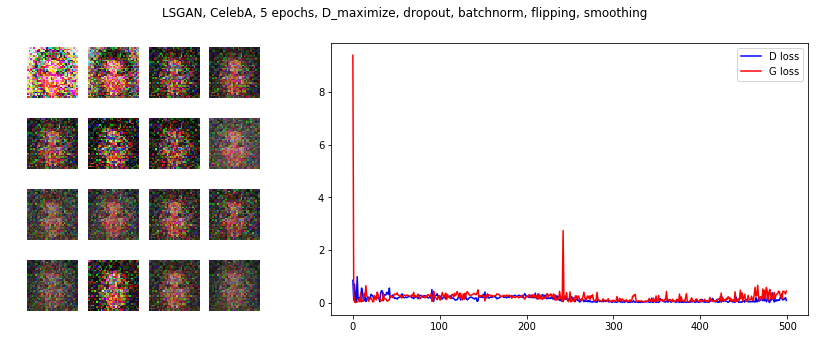

In [38]:
for config in [Config(dataset_name = 'MNIST', use_least_squares = False),
               Config(dataset_name = 'MNIST', use_least_squares = True),
               Config(dataset_name = 'CelebA', use_least_squares = True)]:
    load_data(config)
    demo(config)